In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

## Data imports

In [ ]:
# read data for Phola
data_for_model = pd.read_csv(r'C:\Users\Shivm\Documents\Masters\Research Project\Eskom air quality data\Eskom Model\PM10 Models\Combined Station Data.csv')
data_for_model.drop(columns=['Location_Marapong', 'Location_Medupi', 'Location_Chicken Farm'], inplace=True)
data_for_model = data_for_model[data_for_model['Location_Phola']==True]
data_for_model['NO1'] = data_for_model['NO1'].fillna(data_for_model['NOX'] - data_for_model['NO2'])

data_for_model

,Date,Wind,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Temp,NO1,Date Time,Hour,Month,DayOfWeek,Wind_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend
307249,2016/02/04 12:20:00,2.623786,59.86,27.240,45.74,44.57,-2.518538,-0.735675,0.236,847.0,27.97,20.351,2016-02-04 12:20:00,12,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.623786,NaN,2.623786,NaN,2.623786,NaN,2.623786,NaN,59.860000,NaN,59.8600,NaN,59.8600,NaN,59.8600,NaN,27.240000,NaN,27.240000,NaN,27.240000,NaN,27.240000,NaN,45.740000,NaN,45.740000,NaN,45.740000,NaN,45.740000,NaN,44.570000,NaN,44.570000,NaN,44.570000,NaN,44.570000,NaN,-2.518538,NaN,-2.518538,NaN,-2.518538,NaN,-2.518538,NaN,-0.735675,NaN,-0.735675,NaN,-0.735675,NaN,-0.735675,NaN,0.236000,NaN,0.236000,NaN,0.236000,NaN,0.236000,NaN,847.000000,NaN,847.000000,NaN,847.000000,NaN,847.000000,NaN,27.970000,NaN,27.970000,NaN,27.970000,NaN,27.970000,NaN,20.351000,NaN,20.351000,NaN,20.351000,NaN,20.351000,NaN,True,False,False,True,False,True,False
307250,2016/02/04 12:30:00,2.990960,60.12,24.430,42.08,46.32,-2.888250,-0.777082,0.222,847.0,28.26,19.431,2016-02-04 12:30:00,12,2,3,2.623786,59.86,27.240,45.74,44.57,-2.518538,-0.735675,0.236,847.0,27.97,20.351,2.807373,0.259631,2.807373,0.259631,2.807373,0.259631,2.807373,0.259631,59.990000,0.183848,59.9900,0.183848,59.9900,0.183848,59.9900,0.183848,25.835000,1.986970,25.835000,1.986970,25.835000,1.986970,25.835000,1.986970,43.910000,2.588011,43.910000,2.588011,43.910000,2.588011,43.910000,2.588011,45.445000,1.237437,45.445000,1.237437,45.445000,1.237437,45.445000,1.237437,-2.703394,0.261425,-2.703394,0.261425,-2.703394,0.261425,-2.703394,0.261425,-0.756379,0.029279,-0.756379,0.029279,-0.756379,0.029279,-0.756379,0.029279,0.229000,0.009899,0.229000,0.009899,0.229000,0.009899,0.229000,0.009899,847.000000,0.000000,847.000000,0.000000,847.000000,0.000000,847.000000,0.000000,28.115000,0.205061,28.115000,0.205061,28.115000,0.205061,28.115000,0.205061,19.891000,0.650538,19.891000,0.650538,19.891000,0.650538,19.891000,0.650538,True,False,False,True,False,True,False
307251,2016/02/04 12:40:00,2.363760,60.17,23.170,40.94,45.37,-2.359484,0.142113,0.213,847.0,28.64,19.541,2016-02-04 12:40:00,12,2,3,2.990960,60.12,24.430,42.08,46.32,-2.888250,-0.777082,0.222,847.0,28.26,19.431,2.659502,0.315122,2.659502,0.315122,2.659502,0.315122,2.659502,0.315122,60.050000,0.166433,60.0500,0.166433,60.0500,0.166433,60

In [6]:
#null checks
data_for_model.isna().sum()

Date                  0
Wind                  1
SO2                1430
NO2                5213
NOX                5215
                   ... 
Season_Spring         0
Season_Summer         0
Season_Winter         0
DayType_Weekday       0
DayType_Weekend       0
Length: 122, dtype: int64

In [7]:
data_for_model['Date Time'] = pd.to_datetime(data_for_model['Date Time'])
data_for_model['Year'] = data_for_model['Date Time'].dt.year
data_for_model.drop(columns=['Date', 'Date Time'], inplace=True)


In [8]:
data_for_model.columns

Index(['Wind', 'SO2', 'NO2', 'NOX', 'PM10', 'wind_x', 'wind_y', 'PM2.5',
       'Pressure', 'Temp',
       ...
       'NO1_roll24_mean', 'NO1_roll24_std', 'Location_Phola', 'Season_Autumn',
       'Season_Spring', 'Season_Summer', 'Season_Winter', 'DayType_Weekday',
       'DayType_Weekend', 'Year'],
      dtype='object', length=121)

## Create Target variable and rolling features

In [ ]:
data_for_model['PM2.5_lag1'] = data_for_model['PM2.5'].shift(1)
data_for_model['PM2.5_lag2'] = data_for_model['PM2.5'].shift(2)
data_for_model['PM2.5_lag3'] = data_for_model['PM2.5'].shift(3)
data_for_model['PM2.5_t+3'] = data_for_model['PM2.5'].shift(-3)
#data_for_model['PM2.5_t+6'] = data_for_model['PM2.5'].shift(-6)
#data_for_model['PM2.5_t+12'] = data_for_model['PM2.5'].shift(-12)


# Rolling means with different windows, shifted by 1 to prevent leakage
# data_for_model['PM2.5_roll3_mean'] = data_for_model['PM2.5'].rolling(window=3).mean().shift(1)
# data_for_model['PM2.5_roll6_mean'] = data_for_model['PM2.5'].rolling(window=6).mean().shift(1)
# data_for_model['PM2.5_roll12_mean'] = data_for_model['PM2.5'].rolling(window=12).mean().shift(1)
# data_for_model['PM2.5_roll24_mean'] = data_for_model['PM2.5'].rolling(window=24).mean().shift(1)
# data_for_model['PM2.5_roll3_std'] = data_for_model['PM2.5'].rolling(3).std().shift(1)
# data_for_model['PM2.5_roll6_std'] = data_for_model['PM2.5'].rolling(6).std().shift(1)
# data_for_model['PM2.5_roll12_std'] = data_for_model['PM2.5'].rolling(12).std().shift(1)
# data_for_model['PM2.5_roll24_std'] = data_for_model['PM2.5'].rolling(24).std().shift(1)
data_for_model['PM2.5_diff1'] = data_for_model['PM2.5'] - data_for_model['PM2.5'].shift(1)
data_for_model['Temp_diff1'] = data_for_model['Temp'] - data_for_model['Temp'].shift(1)


data_for_model = data_for_model.dropna().reset_index(drop=True)
# # # Split by year
df_train = data_for_model[(data_for_model['Year'] >= 2005) & (data_for_model['Year'] <= 2015)]
df_test = data_for_model[data_for_model['Year'] == 2016]
df_val = data_for_model[data_for_model['Year'] == 2017]


In [10]:
data_for_model

,Wind,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Temp,NO1,Hour,Month,DayOfWeek,Wind_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend,Year,PM2.5_t+3,PM2.5_diff1,Temp_diff1
0,2.990960,60.120,24.430,42.080,46.32,-2.888250,-0.777082,0.222,847.0,28.26,19.431,12,2,3,2.623786,59.860,27.240,45.740,44.57,-2.518538,-0.735675,0.236,847.0,27.97,20.351,2.807373,0.259631,2.807373,0.259631,2.807373,0.259631,2.807373,0.259631,59.990000,0.183848,59.990000,0.183848,59.990000,0.183848,59.990000,0.183848,25.835000,1.986970,25.835000,1.986970,25.835000,1.986970,25.835000,1.986970,43.910000,2.588011,43.910000,2.588011,43.910000,2.588011,43.910000,2.588011,45.445000,1.237437,45.445000,1.237437,45.445000,1.237437,45.445000,1.237437,-2.703394,0.261425,-2.703394,0.261425,-2.703394,0.261425,-2.703394,0.261425,-0.756379,0.029279,-0.756379,0.029279,-0.756379,0.029279,-0.756379,0.029279,0.229000,0.009899,0.229000,0.009899,0.229000,0.009899,0.229000,0.009899,847.000000,0.000000,847.000000,0.000000,847.000000,0.000000,847.000000,0.000000,28.115000,0.205061,28.115000,0.205061,28.115000,0.205061,28.115000,0.205061,19.891000,0.650538,19.891000,0.650538,19.891000,0.650538,19.891000,0.650538,True,False,False,True,False,True,False,2016,0.226,-0.014,0.29
1,2.363760,60.170,23.170,40.940,45.37,-2.359484,0.142113,0.213,847.0,28.64,19.541,12,2,3,2.990960,60.120,24.430,42.080,46.32,-2.888250,-0.777082,0.222,847.0,28.26,19.431,2.659502,0.315122,2.659502,0.315122,2.659502,0.315122,2.659502,0.315122,60.050000,0.166433,60.050000,0.166433,60.050000,0.166433,60.050000,0.166433,24.946667,2.083611,24.946667,2.083611,24.946667,2.083611,24.946667,2.083611,42.920000,2.507828,42.920000,2.507828,42.920000,2.507828,42.920000,2.507828,45.420000,0.876071,45.420000,0.876071,45.420000,0.876071,45.420000,0.876071,-2.588757,0.271286,-2.588757,0.271286,-2.588757,0.271286,-2.588757,0.271286,-0.456881,0.519158,-0.456881,0.519158,-0.456881,0.519158,-0.456881,0.519158,0.223667,0.011590,0.223667,0.011590,0.223667,0.011590,0.223667,0.011590,847.000000,0.000000,847.000000,0.000000,847.000000,0.000000,847.000000,0.000000,28.290000,0.336006,28.290000,0.336006,28.290000,0.336006,28.290000,0.336006,19.774333,0.502427,19.774333,0.502427,19.774333,0.502427,19.774333,0.502427,True,False,False,True,False,True,False,2016,0.213,-0.009,0.38
2,1.443213,53.420,21.450,35.820,46.22,-1.442090,0.056930,0.222,847.0,29.20,16.061,12,

## Correlation Matrix to identify best features

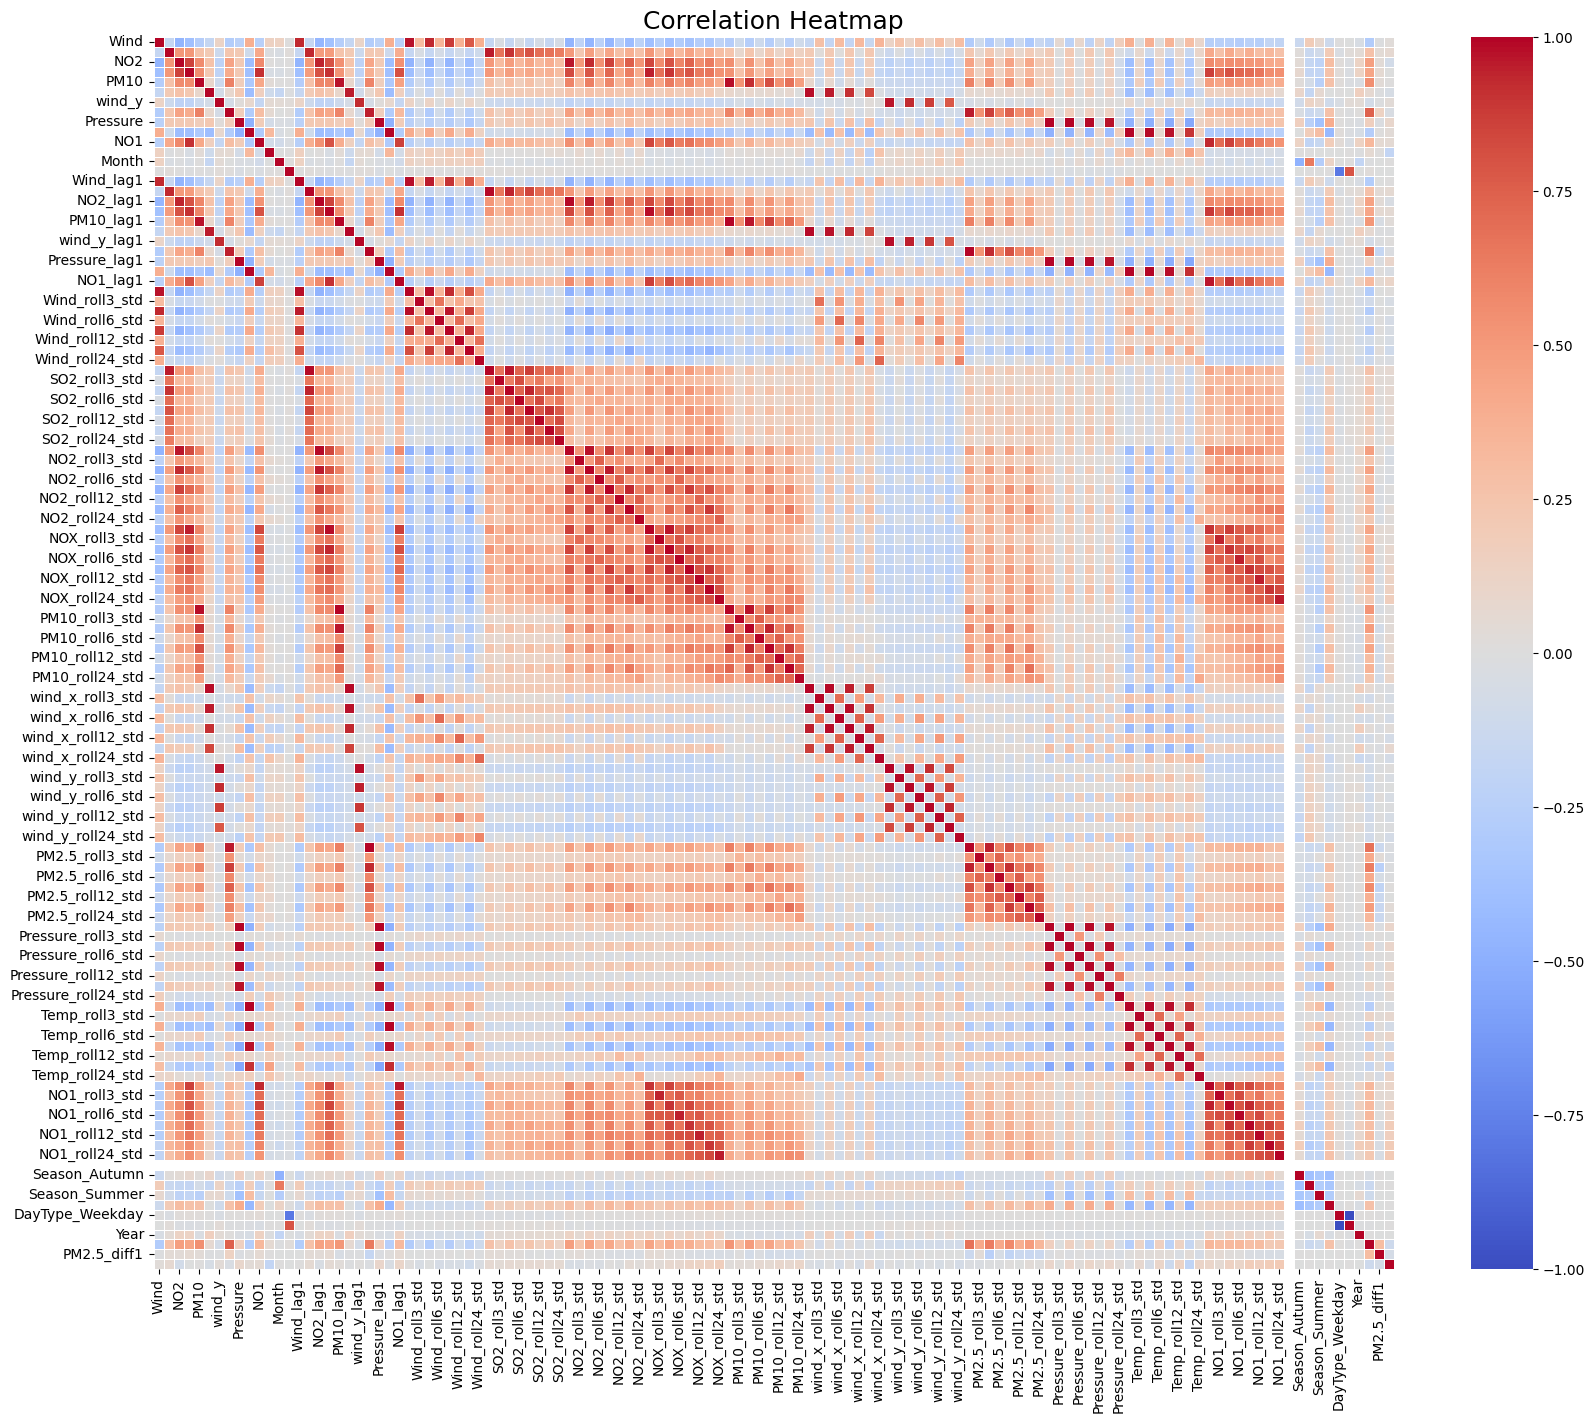

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = data_for_model.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Generate a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)

# Add title
plt.title('Correlation Heatmap', fontsize=18)
plt.show()


In [21]:
reduced_df

,Wind,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Temp,Hour,Month,DayOfWeek,Wind_roll3_std,Wind_roll6_std,Wind_roll12_std,Wind_roll24_std,SO2_roll3_std,SO2_roll6_std,SO2_roll12_std,SO2_roll24_std,NO2_roll3_std,NO2_roll6_std,NO2_roll12_std,NO2_roll24_std,NOX_roll3_std,NOX_roll6_std,NOX_roll12_std,NOX_roll24_std,PM10_roll3_std,PM10_roll6_std,PM10_roll12_std,PM10_roll24_std,wind_x_roll3_std,wind_x_roll6_std,wind_x_roll12_std,wind_x_roll24_std,wind_y_roll3_std,wind_y_roll6_std,wind_y_roll12_std,wind_y_roll24_std,PM2.5_roll3_std,PM2.5_roll6_std,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_std,Pressure_roll6_std,Pressure_roll12_std,Pressure_roll24_std,Temp_roll3_std,Temp_roll6_std,Temp_roll12_std,Temp_roll24_std,NO1_roll24_mean,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend,Year,PM2.5_t+3,PM2.5_diff1,Temp_diff1
0,2.990960,60.120,24.430,42.080,46.32,-2.888250,-0.777082,0.222,847.0,28.26,12,2,3,0.259631,0.259631,0.259631,0.259631,0.183848,0.183848,0.183848,0.183848,1.986970,1.986970,1.986970,1.986970,2.588011,2.588011,2.588011,2.588011,1.237437,1.237437,1.237437,1.237437,0.261425,0.261425,0.261425,0.261425,0.029279,0.029279,0.029279,0.029279,0.009899,0.009899,0.009899,0.229000,0.009899,0.000000,0.000000,0.000000,0.000000,0.205061,0.205061,0.205061,0.205061,19.891000,True,False,False,True,False,True,False,2016,0.226,-0.014,0.29
1,2.363760,60.170,23.170,40.940,45.37,-2.359484,0.142113,0.213,847.0,28.64,12,2,3,0.315122,0.315122,0.315122,0.315122,0.166433,0.166433,0.166433,0.166433,2.083611,2.083611,2.083611,2.083611,2.507828,2.507828,2.507828,2.507828,0.876071,0.876071,0.876071,0.876071,0.271286,0.271286,0.271286,0.271286,0.519158,0.519158,0.519158,0.519158,0.011590,0.011590,0.011590,0.223667,0.011590,0.000000,0.000000,0.000000,0.000000,0.336006,0.336006,0.336006,0.336006,19.774333,True,False,False,True,False,True,False,2016,0.213,-0.009,0.38
2,1.443213,53.420,21.450,35.820,46.22,-1.442090,0.056930,0.222,847.0,29.20,12,2,3,0.778493,0.660334,0.660334,0.660334,3.882761,3.317784,3.317784,3.317784,1.495906,2.439459,2.439459,2.439459,3.334207,4.098207,4.098207,4.098207,0.522015,0.819553,0.819553,0.819553,0.731731,0.614635,0.614635,0.614635,0.507896,0.495665,0.495665,0.495665,0.005196,0.009500,0.009500,0.223250,0.009500,0.000000,0.000000,0.000000,0.000000,0.472864,0.531311,0.531311,0.531311,18.846000,True,False,False,True,False,True,False,2016,0.201,0.009,0.56
3,3.096310,39.400,17.160,26.600,48.07,-3.096225,0.022881,0.226,852.0,29.39,13,2,3,0.828328,0.660917,0.660917,0.660917,10.594934,8.966537,8.966537,8.966537,3.095228,3.744296,3.744296,3.744296,7.267031,7.409985,7.409985,7.409985,1.380519,1.305469,1.305469,1.305469,0.828710,0.639892,0.639892,0.639892,0.061417,0.457106,0.457106,0.457106,0.006658,0.008319,0.008319,0.223800,0.008319,2.886751,2.236068,2.236068,2.236068,0.389915,0.603299,0.603299,0.603299,17.307000,True,False,False,True,False,True,False,2016,0.210,0.004,0.19
4,3.441108,30.430,14.230,21.570,43.44,-3.439926,0.090168,0.213,847.0,29.15,13,2,3,1.067958,0.704226,0.704226,0.704226,11.587072,12.713595,12.713595,12.713595,3.631285,4.810863,4.810863,4.810863,7.226938,9.498363,9.498363,9.498363,2.330515,1.597357,1.597357,1.597357,1.068148,0.698078,0.698078,0.698078,0.033644,0.432874,0.432874,0.432874,0.006658,0.008649,0.008649,0.222000,0.008649,2.886751,2.041241,2.041241,2.041241,0.126623,0.571084,0.571084,0.571084,15.857500,True,False,False,True,False,True,False,2016,0.222,-0.013,-0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76789,1.579270,0.811,2.377,2.648,19.25,0.527443,1.488589,24.660,847.0,17.38,22,12,0,0.153236,0.118427,0.146453,0.597246,0.098185,0.117222,0.133641,0.333692,0.228843,0.403845,0.304774,1.249163,0.209132,0.374041,0.304

In [ ]:
# Compute correlations with the target
target = 'PM2.5_t+3'
correlations = data_for_model.corr()[target].drop(target)

# Sort by absolute correlation (strongest relationships first)
feature_ranking = correlations.abs().sort_values(ascending=False)

# Display top 15 features most correlated with PM2.5_t+12
print("Top correlated features with PM2.5_t+3:\n")
print(feature_ranking.head(20))

Top correlated features with PM2.5_t+3:

PM2.5                0.743604
PM10                 0.549514
PM2.5_roll24_mean    0.485331
NO2                  0.474465
NOX                  0.440099
PM2.5_roll6_std      0.416422
PM2.5_roll3_std      0.415260
PM2.5_roll12_std     0.389715
PM2.5_roll24_std     0.336025
NOX_roll6_std        0.328731
PM10_roll6_std       0.315689
NOX_roll3_std        0.310795
PM10_roll3_std       0.308737
NOX_roll12_std       0.299625
PM2.5_diff1          0.298255
PM10_roll12_std      0.297406
NO2_roll6_std        0.283799
Wind                 0.283164
Temp                 0.273302
NO2_roll12_std       0.270393
Name: PM2.5_t+3, dtype: float64


In [10]:
feature_ranking

PM2.5                    0.753465
PM2.5_roll3_mean         0.683765
PM2.5_lag1               0.657957
PM2.5_roll6_mean         0.635932
PM2.5_roll12_mean        0.578539
                           ...   
Pressure_roll6_std       0.007616
Month                    0.002084
Location_Chicken Farm         NaN
Location_Marapong             NaN
Location_Phola                NaN
Name: PM2.5_t+3, Length: 115, dtype: float64

In [11]:
data_for_model

,Wind,Wind Dir,SO2,NO2,NOX,PM10,PM2.5,Pressure,Temp,NO1,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Chicken Farm,Location_Marapong,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend,Year,PM2.5_t+3,PM2.5_diff1,Temp_diff1
0,2.990960,254.941200,60.120,24.430,42.080,46.32,0.222,847.0,28.26,19.431,12,2,3,2.623786,253.716700,59.860,27.240,45.740,44.57,0.236,847.0,27.97,20.351,2.807373,0.259631,2.807373,0.259631,2.807373,0.259631,2.807373,0.259631,254.328950,0.865852,254.328950,0.865852,254.328950,0.865852,254.328950,0.865852,59.990000,0.183848,59.990000,0.183848,59.990000,0.183848,59.990000,0.183848,25.835000,1.986970,25.835000,1.986970,25.835000,1.986970,25.835000,1.986970,43.910000,2.588011,43.910000,2.588011,43.910000,2.588011,43.910000,2.588011,45.445000,1.237437,45.445000,1.237437,45.445000,1.237437,45.445000,1.237437,0.229000,0.009899,0.229000,0.009899,0.229000,0.009899,0.229000,0.009899,847.000000,0.000000,847.000000,0.000000,847.000000,0.000000,847.000000,0.000000,28.115000,0.205061,28.115000,0.205061,28.115000,0.205061,28.115000,0.205061,19.891000,0.650538,19.891000,0.650538,19.891000,0.650538,19.891000,0.650538,False,False,True,False,False,True,False,True,False,2016,0.226,-0.014,0.29
1,2.363760,273.446800,60.170,23.170,40.940,45.37,0.213,847.0,28.64,19.541,12,2,3,2.990960,254.941200,60.120,24.430,42.080,46.32,0.222,847.0,28.26,19.431,2.659502,0.315122,2.659502,0.315122,2.659502,0.315122,2.659502,0.315122,260.701567,11.054663,260.701567,11.054663,260.701567,11.054663,260.701567,11.054663,60.050000,0.166433,60.050000,0.166433,60.050000,0.166433,60.050000,0.166433,24.946667,2.083611,24.946667,2.083611,24.946667,2.083611,24.946667,2.083611,42.920000,2.507828,42.920000,2.507828,42.920000,2.507828,42.920000,2.507828,45.420000,0.876071,45.420000,0.876071,45.420000,0.876071,45.420000,0.876071,0.223667,0.011590,0.223667,0.011590,0.223667,0.011590,0.223667,0.011590,847.000000,0.000000,847.000000,0.000000,847.000000,0.000000,847.000000,0.000000,28.290000,0.336006,28.290000,0.336006,28.290000,0.336006,28.290000,0.336006,19.774333,0.502427,19.774333,0.502427,19.774333,0.502427,19.774333,0.502427,False,False,True,False,False,True,False,True,False,2016,0.213,-0.009,0.38
2,1.443213,272.260700,53.420,21.450,35.820,46.22,0.222,847.0,29.20,16.061,12,2,3,2.363760,273.446800,60.170,23.170,40.940,45.37,0.213,847.0,28.64,19.541,2.265978,0.778493,2.355430,0.660334,2.355430,0.660334,2.355430,0.660334,266.882900,10.358806,263.591350,10.717919,263.591350,10.717919,263.591350,10.717919,57.903333,3.882761,58.392500,3

## Feature Selection

In [ ]:
features = feature_ranking.head(20).index.tolist()

In [25]:
X = pd.concat([df_train[features], df_test[features]])#data_for_model[features]
y = pd.concat([df_train['PM2.5_t+3'], df_test['PM2.5_t+3']])#data_for_model['PM2.5_t+3']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [14]:
y

0        0.226
1        0.213
2        0.201
3        0.210
4        0.222
         ...  
79673    3.836
79674    0.195
79675    0.049
79676    0.110
79677    0.112
Name: PM2.5_t+3, Length: 79678, dtype: float64

## Data splitting for models

In [26]:
# Let's use 80% of the data for training, 20% for testing
split_idx = int(len(X_scaled) * 0.8)

X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


## LSTM Model (Neural Network)

In [27]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1123.1410 - val_loss: 775.9550
Epoch 2/50
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 597.7286 - val_loss: 746.3718
Epoch 3/50
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 586.0015 - val_loss: 745.2108
Epoch 4/50
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 583.2518 - val_loss: 735.5817
Epoch 5/50
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 562.2293 - val_loss: 720.7927
Epoch 6/50
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 563.7567 - val_loss: 725.8787
Epoch 7/50
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 559.4437 - val_loss: 720.3519
Epoch 8/50
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 2s 905us/step - loss: 546.3317 - val_loss: 756.7288
Epoch 9/50
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 2s 928us/step - loss: 575.6396 - val_loss: 726.7189
Epoch 10/50
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 2s 968us/step - loss: 557.3143 - val_loss: 721.6467
Epoch 11/50
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 551.0193 

In [28]:
#Prediction accuracy
y_pred = model.predict(X_test).flatten()

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R²: {r2}")
print(f"RMSE: {rmse}")


480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
R²: 0.7302560667322062
RMSE: 26.440586934386463


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
X_val # Phola has no 2018 data

,PM2.5,PM2.5_lag1,PM2.5_roll3_mean,PM2.5_roll6_mean,PM2.5_roll12_mean,PM10,PM2.5_roll24_mean,PM10_roll3_mean,PM10_lag1,PM10_roll6_mean,PM10_roll12_mean,NO2,NO2_roll3_mean,NO2_lag1,NO2_roll6_mean,PM10_roll24_mean,NO2_roll12_mean,NOX,PM2.5_roll6_std,NOX_roll3_mean


In [18]:
#Validation data prediction
X_val = df_val[features]
y_val = df_val['PM2.5_t+3']

X_val_scaled = scaler.fit_transform(X_val)


y_pred_val = model.predict(X_val_scaled)

r2 = r2_score(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)

print(f"R²: {r2}")
print(f"RMSE: {rmse}")

ValueError: Found array with 0 sample(s) (shape=(0, 20)) while a minimum of 1 is required by StandardScaler.

In [ ]:
last_known_data = data_for_model.iloc[-1][features].values.reshape(1, -1)
last_known_data_scaled = scaler.transform(last_known_data)

forecast_3hr = model.predict(last_known_data_scaled)[0][0]
print(f"Forecasted PM2.5 (3 hrs ahead): {forecast_3hr}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Forecasted PM2.5 (3 hrs ahead): 34.90578842163086


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


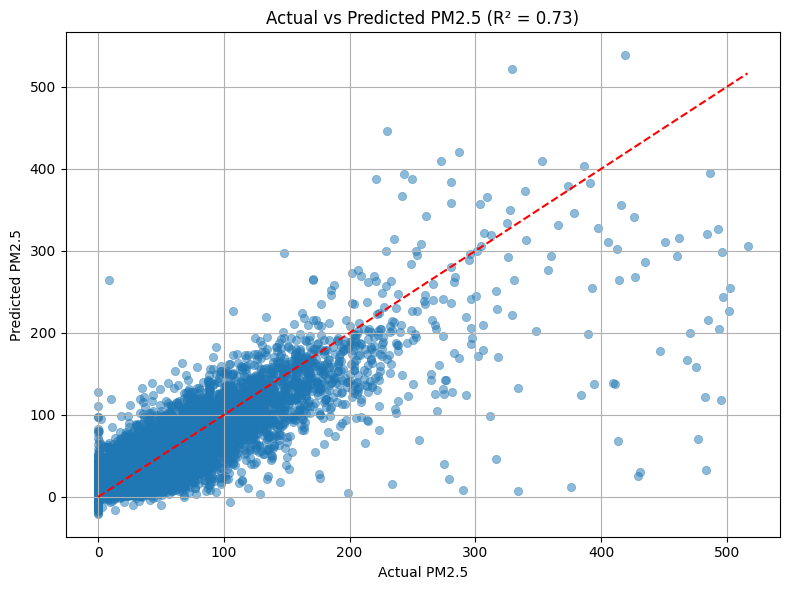

In [29]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title(f'Actual vs Predicted PM2.5 (R² = {r2_score(y_test, y_pred):.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
y_val

89545      6.033
89546      7.967
89547     12.030
89548     12.600
89549     13.200
           ...  
103855    23.430
103856    29.240
103857    31.590
103858    27.970
103859    24.740
Name: PM2.5_t+3, Length: 14315, dtype: float64

# Testing out XGBoost Regressor and Random Forrest Regressor

In [30]:
X = pd.concat([df_train[features], df_test[features]])#data_for_model[features]
y = pd.concat([df_train['PM2.5_t+3'], df_test['PM2.5_t+3']])#data_for_model['PM2.5_t+3']

In [31]:
#Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
#Random Forrest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)


In [33]:
#XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)


## Model Evaluation

In [34]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Performance:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
    print("R2 Score:", r2_score(y_true, y_pred))

evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)



Random Forest Performance:
MAE: 14.891647529787095
RMSE: 22.774587163522252
R2 Score: 0.6950438679729996

XGBoost Performance:
MAE: 15.194305737116252
RMSE: 22.890790122642382
R2 Score: 0.6919239686364618


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'Random Forest: Actual vs Predicted')

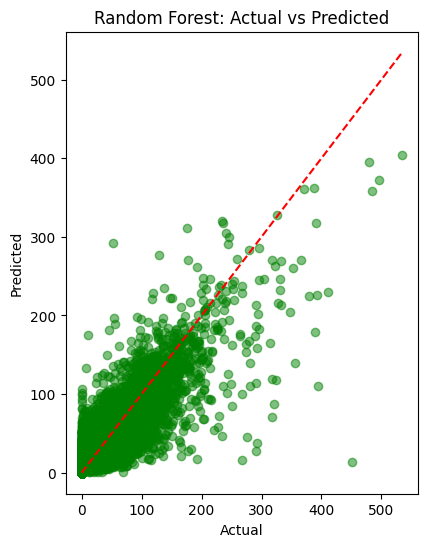

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_preds, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest: Actual vs Predicted")

Text(0.5, 1.0, 'XGBoost: Actual vs Predicted')

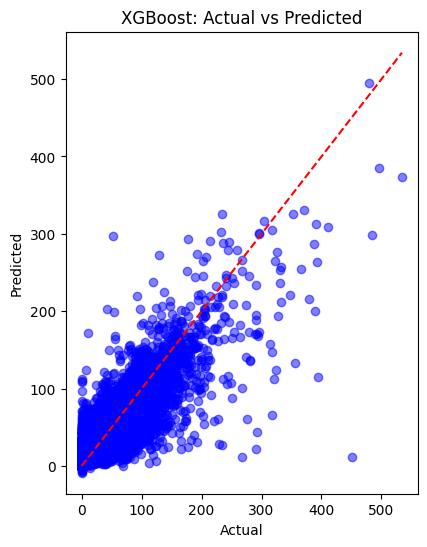

In [36]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_preds, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost: Actual vs Predicted")

In [ ]:
#Validation performance

rf_val = rf.predict(X_val)

xgb_val = xgb.predict(X_val)

evaluate_model("Random Forrest", y_val, rf_val)
evaluate_model("XGBoost", y_val, xgb_val )


Random Forrest Performance:
MAE: 6.5796065525672365
RMSE: 11.392128570626655
R2 Score: 0.6363194480431638

XGBoost Performance:
MAE: 6.431195657281051
RMSE: 11.443756556320992
R2 Score: 0.6330156510562247


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'Random Forest Validation: Actual vs Predicted')

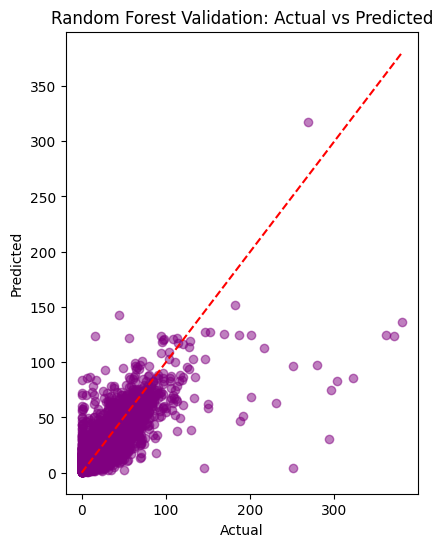

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, rf_val, alpha=0.5, color='purple')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Validation: Actual vs Predicted")

Text(0.5, 1.0, 'XGBoost Validation: Actual vs Predicted')

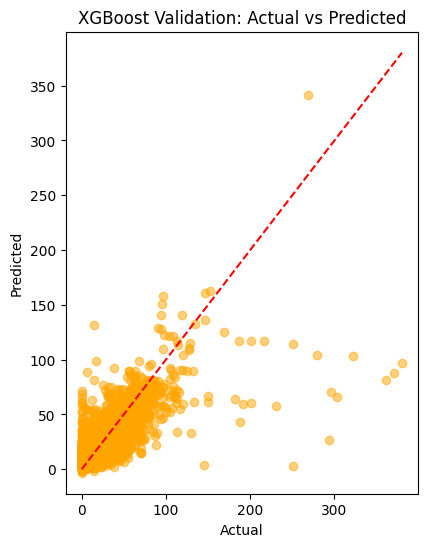

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, xgb_val, alpha=0.5, color='orange')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost Validation: Actual vs Predicted")

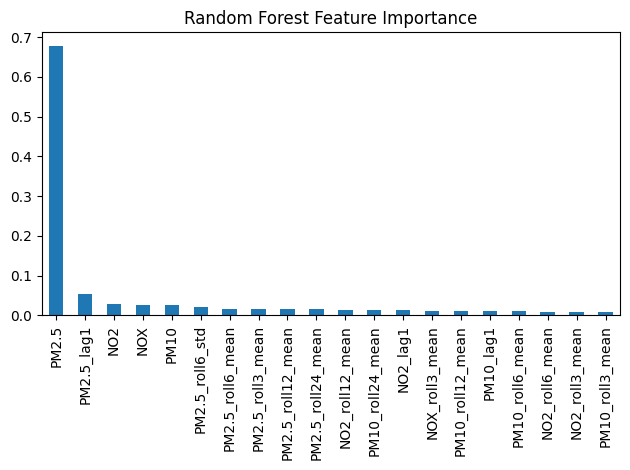

In [ ]:
import matplotlib.pyplot as plt

# For Random Forest
rf_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
rf_importance.plot(kind='bar', title='Random Forest Feature Importance')
plt.tight_layout()
plt.show()




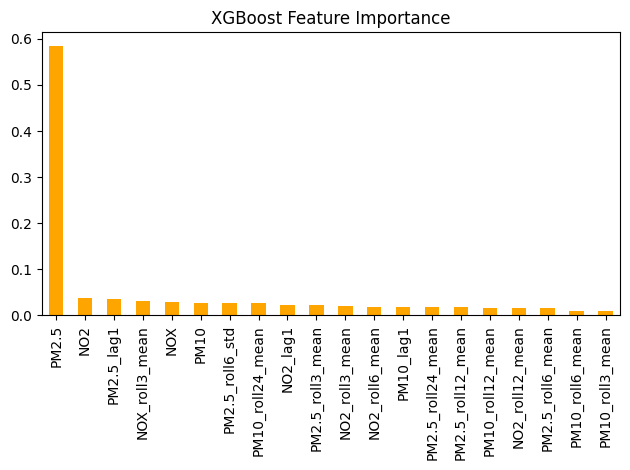

In [ ]:
# For XGBoost
xgb_importance = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=False)
xgb_importance.plot(kind='bar', title='XGBoost Feature Importance', color='orange')
plt.tight_layout()
plt.show()